# Downstream prediction 

Run this notebook on google colab to use a free GPU! 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/helicalAI/helical/blob/main/examples/notebooks/Hyena-DNA-Inference.ipynb)

In this notebook, a HyenaDNA model is used for various classifications tasks with a given sequence of nucleotides.

A HyenaDNA model (2 layers and width 256) is used to create embeddings of nucleotides.

A neural network is then trained, using the embeddings as inputs, to make a prediction.

This notebook can be used for any of the 18 [nucleotide transformer downstream tasks](https://huggingface.co/datasets/InstaDeepAI/nucleotide_transformer_downstream_tasks).

In [1]:
# !pip install helical

In [1]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from datasets import DatasetDict
import torch
from torch import nn
from typing import Tuple
import logging, warnings
from torch.nn.functional import one_hot
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

logging.getLogger().setLevel(logging.ERROR)

warnings.filterwarnings("ignore")

/home/matthew/miniconda3/envs/matt-helical/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Use the Helical package to get the Hyena model
We use a small HyenaDNA model with 2 layers and width 256.

In [ ]:
from helical.models.hyena_dna import HyenaDNA, HyenaDNAConfig  
device = "cuda" if torch.cuda.is_available() else "cpu"
configurer = HyenaDNAConfig(model_name="hyenadna-tiny-1k-seqlen-d256", device=device, batch_size=5)
hyena_model = HyenaDNA(configurer=configurer)

### Download the dataset
Several datasets are available from the [Nucleotide Transformer](https://arxiv.org/abs/2306.15794).
We can select any of the 18 downstream tasks. Let us take the `promoter_tata` as an example.

In [3]:
from datasets import load_dataset
label = "promoter_tata"

dataset = load_dataset("InstaDeepAI/nucleotide_transformer_downstream_tasks",  trust_remote_code=True).filter(lambda x: x["task"] == "promoter_tata")

Filter: 100%|██████████| 48797/48797 [00:00<00:00, 492263.67 examples/s]


To familiarize ourselves with the data, we can print the first seqence and see if it is a splice site acceptor or not:

In [4]:
print("Nucleotide sequence:", dataset["train"]["sequence"][0][:10], "...")
print("Label name:", dataset["train"].config_name, "and value:", dataset["train"]["label"][0])
num_classes = len(set(dataset["train"]["label"]))
print("Number of classes:", num_classes)

Nucleotide sequence: CGCTCCCCCA ...
Label name: default and value: 0
Number of classes: 2


Define a function that gets the embeddings for each nucleotide sequence in the training dataset.

According to the HyenaDNA [paper](https://arxiv.org/pdf/2306.15794): "[they] average across the tokens to obtain a single classification token".

In our code below, the Hyena model returns a (302, 256) matrix. We average column wise resulting in a vector of shape (256, ) for each observation.

During the training process, we also found that it is beneficial to normalize the data row-wise.

In [5]:
def get_model_inputs(dataset: DatasetDict) -> Tuple[np.ndarray, np.ndarray]:
    """
    Parameters
    ----------
    dataset : DatasetDict
        The dataset containing the sequences and labels.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        A tuple containing the input features and labels.
    """
    processed_data = hyena_model.process_data(dataset["sequence"])

    embeddings = hyena_model.get_embeddings(processed_data)
    embeddings = embeddings.mean(axis=1)
    means = np.mean(embeddings, axis=1, keepdims=True)
    stds = np.std(embeddings, axis=1, keepdims=True)

    x = (embeddings - means) / stds

    return x, dataset["label"]

It may be beneficial to do this step once and save the output in a `.npy` file.

In [6]:
x, y = get_model_inputs(dataset["train"])
#np.save(f"data/train/x_{label}_norm_256", x)
#np.save(f"data/train/y_{label}_norm_256", y)

INFO:helical.models.hyena_dna.model:Processing data for HyenaDNA.


INFO:helical.models.hyena_dna.model:Succesfully prepared the HyenaDNA Dataset.
INFO:helical.models.hyena_dna.model:Started getting embeddings:
Getting embeddings: 100%|██████████| 1102/1102 [00:03<00:00, 337.42it/s]
INFO:helical.models.hyena_dna.model:Finished getting embeddings.


Load the data and one-hot-encode the labels.

We split the training set into actual training data and a test set. 

This is optional and the entire dataset can be used for training. We did this to avoid data leakage by not touching the test set during the training process.

In [7]:
#x = np.load(f"data/train/x_{label}_norm_256.npy")
#y = np.load(f"data/train/y_{label}_norm_256.npy")

# # One-hot encode the labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = one_hot(torch.tensor(y_encoded),num_classes).float()
y_encoded


tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        ...,
        [1., 0.],
        [0., 1.],
        [1., 0.]])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.1, random_state=42)

In [9]:
input_shape = configurer.config['d_model']

# Define the model architecture
head_model = nn.Sequential(
    nn.Linear(input_shape, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(64, num_classes),
    nn.Softmax(dim=1)
    )

print(head_model)

Sequential(
  (0): Linear(in_features=256, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.4, inplace=False)
  (6): Linear(in_features=128, out_features=128, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.4, inplace=False)
  (9): Linear(in_features=128, out_features=64, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.4, inplace=False)
  (12): Linear(in_features=64, out_features=2, bias=True)
  (13): Softmax(dim=1)
)


In [10]:
def train_model(model: nn.Sequential,
                X_train: torch.Tensor,  
                y_train: torch.Tensor,  
                X_val: torch.Tensor, 
                y_val: torch.Tensor, 
                optimizer = optim.Adam, 
                loss_fn = nn.CrossEntropyLoss(),
                num_epochs = 25, 
                batch = 64):    

    # Create DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

    # Validation dataset
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    # Ensure model is in training mode
    model.train()

    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_X)
            
            # Compute loss
            loss = loss_fn(outputs, batch_y)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase (optional)
        model.eval()
        with torch.no_grad():
            val_losses = []
            for val_X, val_y in val_loader:
                val_outputs = model(val_X)
                val_loss = loss_fn(val_outputs, val_y)
                val_losses.append(val_loss.item())
            
            print(f"Epoch {epoch+1}, Validation Loss: {sum(val_losses)/len(val_losses)}")
        
        # Set back to training mode for next epoch
        model.train()
        
    model.eval()   
    return model

### Define and train the model

In [11]:
trained_model = train_model(head_model, 
                            torch.from_numpy(X_train), 
                            y_train, 
                            torch.from_numpy(X_test), 
                            y_test,
                            optim.Adam(head_model.parameters(), lr=0.001),
                            nn.CrossEntropyLoss())

Epoch 1, Validation Loss: 0.6822912096977234
Epoch 2, Validation Loss: 0.5138157142533196
Epoch 3, Validation Loss: 0.4389282796117995
Epoch 4, Validation Loss: 0.45615750551223755
Epoch 5, Validation Loss: 0.45748764938778347
Epoch 6, Validation Loss: 0.43795546558168197
Epoch 7, Validation Loss: 0.43910149070951676
Epoch 8, Validation Loss: 0.42771519554985893
Epoch 9, Validation Loss: 0.41031453013420105
Epoch 10, Validation Loss: 0.4496387706862556
Epoch 11, Validation Loss: 0.4233228928512997
Epoch 12, Validation Loss: 0.4684457348452674
Epoch 13, Validation Loss: 0.41786743534935844
Epoch 14, Validation Loss: 0.4579118854469723
Epoch 15, Validation Loss: 0.41921072867181564
Epoch 16, Validation Loss: 0.4725731909275055
Epoch 17, Validation Loss: 0.4140022893746694
Epoch 18, Validation Loss: 0.41290755073229474
Epoch 19, Validation Loss: 0.4361809558338589
Epoch 20, Validation Loss: 0.42776555485195583
Epoch 21, Validation Loss: 0.4498215946886275
Epoch 22, Validation Loss: 0.4043

In [12]:
X_unseen, y_unseen = get_model_inputs(dataset["test"])
#np.save(f"data/test/x_{label}_norm_256.npy", X_unseen)
#np.save(f"data/test/y_{label}_norm_256.npy", y_unseen)

INFO:helical.models.hyena_dna.model:Processing data for HyenaDNA.
INFO:helical.models.hyena_dna.model:Succesfully prepared the HyenaDNA Dataset.
INFO:helical.models.hyena_dna.model:Started getting embeddings:
Getting embeddings: 100%|██████████| 125/125 [00:00<00:00, 439.64it/s]
INFO:helical.models.hyena_dna.model:Finished getting embeddings.


### Evaluate the model on the test data


In [13]:
#X_unseen = np.load(f"data/test/x_{label}_norm_256.npy")
#y_unseen = np.load(f"data/test/y_{label}_norm_256.npy")

predictions_nn = trained_model(torch.from_numpy(X_unseen))

y_pred = np.array(torch.argmax(predictions_nn, dim=1))
print("Correct predictions: {:.2f}%".format(sum(np.equal(y_pred, y_unseen))*100/len(y_unseen)))


Correct predictions: 88.08%


The [Hyena](https://arxiv.org/pdf/2306.15794) and the [Nucleotide transformer](https://www.biorxiv.org/content/10.1101/2023.01.11.523679v1.full.pdf) papers, report accuracies around 95% for this task. Our results underperform in comparison. This is probably due to the much larger models being used for the NT, while the Hyena model was re-trained from scratch for this task. In future work, we want to achieve these accuracies too with either approaches.

## OPTIONAL
For reference, we also trained an SVM model and obtained similar results (to our small NN).

In [14]:
# Train the SVM model
svm_model = svm.SVC(kernel='rbf', degree=3, C=1, decision_function_shape='ovr')  # One-vs-rest strategy
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
svm_model.fit(X_train, y_train)

,C,1
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [15]:
# Evaluate the model
unseen_predictions_svm = svm_model.predict(X_unseen)

accuracy = accuracy_score(y_unseen, unseen_predictions_svm)
print("Test accuracy: {:.1f}%".format(accuracy*100))


Test accuracy: 89.7%


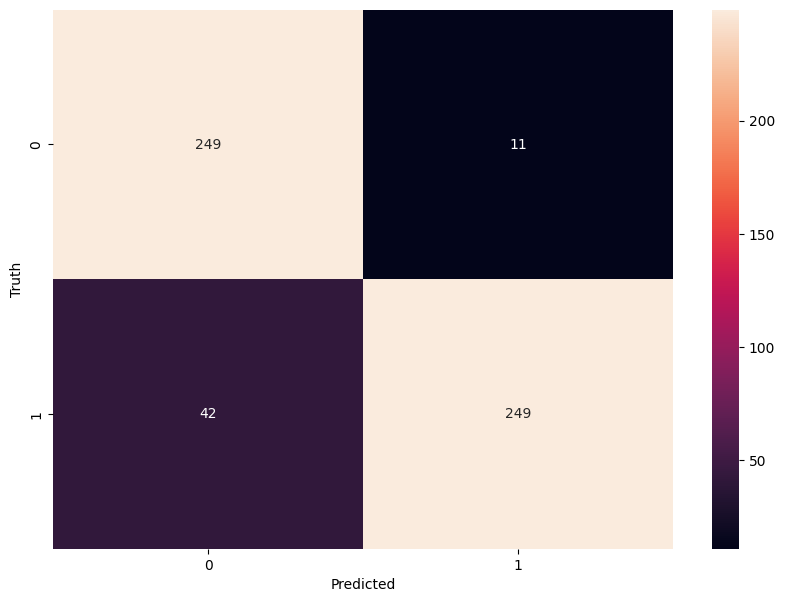

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# NN
# y_true = np.argmax(y_test, axis=1)
# y_pred_classes = np.argmax(predictions_nn, axis=1)

# SVM
y_true = y_test
y_pred_classes = svm_model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Create a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()